Montagem do Google Drive e Descompactação das Imagens

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Doutorado/PSI5796/'
!unzip '/content/drive/MyDrive/Doutorado/PSI5796/imagens.zip'

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: dog-and-cat/training_set/cats/cat.37.jpg  
  inflating: dog-and-cat/training_set/cats/cat.370.jpg  
  inflating: dog-and-cat/training_set/cats/cat.3700.jpg  
  inflating: dog-and-cat/training_set/cats/cat.3701.jpg  
  inflating: dog-and-cat/training_set/cats/cat.3702.jpg  
  inflating: dog-and-cat/training_set/cats/cat.3703.jpg  
  inflating: dog-and-cat/training_set/cats/cat.3704.jpg  
  inflating: dog-and-cat/training_set/cats/cat.3705.jpg  
  inflating: dog-and-cat/training_set/cats/cat.3706.jpg  
  inflating: dog-and-cat/training_set/cats/cat.3707.jpg  
  inflating: dog-and-cat/training_set/cats/cat.3708.jpg  
  inflating: dog-and-cat/training_set/cats/cat.3709.jpg  
  inflating: dog-and-cat/training_set/cats/cat.371.jpg  
  inflating: dog-and-cat/training_set/cats/cat.3710.jpg  
  inflating: dog-and-cat/training_set/cats/cat.3711.jpg  
  inflating: dog-and-cat/training_set/cats/cat.3712.jpg  
  inflating: dog-

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 32
image_size = (128,128)

#Datasets creation from the directory

train_ds = tf.keras.preprocessing.image_dataset_from_directory('dog-and-cat/training_set/', labels='inferred', subset="training", label_mode='categorical', validation_split=0.15, seed=1337, batch_size=batch_size, image_size=image_size, smart_resize=True)
val_ds = tf.keras.preprocessing.image_dataset_from_directory('dog-and-cat/training_set/', labels='inferred', subset="validation", label_mode='categorical', validation_split=0.15, seed=1337, batch_size=batch_size, image_size=image_size, smart_resize=True)

#Rescaling the images values
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

#Performing Data Augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.2)
    ]
)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))



Found 8000 files belonging to 2 classes.
Using 6800 files for training.
Found 8000 files belonging to 2 classes.
Using 1200 files for validation.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 16) 64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 16) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

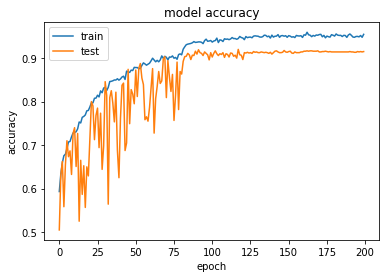

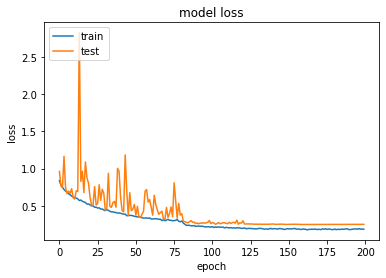

In [ ]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow.keras as keras
from keras.datasets import cifar10
from keras.models import Model, load_model
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, Input, Flatten
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.activations import relu
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from inspect import currentframe, getframeinfo
import numpy as np; import os; import sys
import matplotlib.pyplot as plt; import numpy as np
from keras.callbacks import LearningRateScheduler

#plot the accuracy and loss
def printHistory(history):
  print(history.history.keys())
  plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left'); plt.show()
  plt.plot(history.history['loss']); plt.plot(history.history['val_loss'])
  plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left'); plt.show()

#Resnet Layer
def resnet_layer(inputs, num_filters=16, kernel_size=3,
                 strides=1, activation='relu', batch_normalization=True):
  x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides,
             padding='same', kernel_initializer='he_normal',
             kernel_regularizer=l2(1e-4))(inputs)
  if batch_normalization: x = BatchNormalization()(x)
  if activation is not None: x = Activation(activation)(x)
  return x

#Learning Rate Decrease
def lr_schedule(epoch):
  lr = 1e-3
  if epoch > 180:   lr *= 0.5e-3
  elif epoch > 160: lr *= 1e-3
  elif epoch > 120: lr *= 1e-2
  elif epoch > 80:  lr *= 1e-1
  print('Learning rate: ', lr)
  return lr

#Class and epochs definition
num_classes = 2; epochs = 200
nl, nc = image_size
input_shape = (nl, nc, 3)


inputs = Input(shape=input_shape)
x = resnet_layer(inputs=inputs)

num_filters = 16
y = resnet_layer(inputs=x, num_filters=num_filters, strides=1)
y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
x = keras.layers.add([x, y]); x = Activation('relu')(x)

y = resnet_layer(inputs=x, num_filters=num_filters, strides=1)
y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
x = keras.layers.add([x, y]); x = Activation('relu')(x)

y = resnet_layer(inputs=x, num_filters=num_filters, strides=1)
y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
x = keras.layers.add([x, y]); x = Activation('relu')(x)

num_filters *= 2
y = resnet_layer(inputs=x, num_filters=num_filters, strides=2)
y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1,
                 strides=2, activation=None, batch_normalization=False)
x = keras.layers.add([x, y]); x = Activation('relu')(x)

y = resnet_layer(inputs=x, num_filters=num_filters, strides=1)
y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
x = keras.layers.add([x, y]); x = Activation('relu')(x)

y = resnet_layer(inputs=x, num_filters=num_filters, strides=1)
y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
x = keras.layers.add([x, y]); x = Activation('relu')(x)

num_filters *= 2

y = resnet_layer(inputs=x, num_filters=num_filters, strides=2)

y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1,
                 strides=2, activation=None, batch_normalization=False)
x = keras.layers.add([x, y]); x = Activation('relu')(x)

y = resnet_layer(inputs=x, num_filters=num_filters, strides=1)
y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
x = keras.layers.add([x, y]); x = Activation('relu')(x)

y = resnet_layer(inputs=x, num_filters=num_filters, strides=1)
y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
x = keras.layers.add([x, y]); x = Activation('relu')(x)

x = GlobalAveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(y)

model = Model(inputs=inputs, outputs=outputs);
model.summary()


opt=Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [lr_reducer, lr_scheduler]


history=model.fit(train_ds, epochs=epochs, verbose=2, workers=4, validation_data=val_ds,callbacks=callbacks)

printHistory(history)

model.save('zero.h5')